In [48]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import astropy.units as u
import logging
logging.basicConfig(level=logging.INFO)
import pkg_resources
from astropy.coordinates import Distance
from astropy.constants import k_B, m_e, c, G, M_sun
from agnpy.utils.plot import sed_x_label, sed_y_label
# gammapy modules
from gammapy.modeling.models import (
    SpectralModel,
    Parameter,
    SPECTRAL_MODEL_REGISTRY,
    SkyModel,
)
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
from gammapy.modeling import Fit
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import SSDisk, RingDustTorus
from sherpa import data
from sherpa.models import model
from ruamel.yaml import YAML
from astropy.table import Table
from astropy.coordinates import Distance
from gammapy.estimators import FluxPoints


from gammapy.modeling import Fit
from gammapy.modeling.sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)


In [49]:
yaml = YAML()
# get the main logger
log = logging.getLogger(__name__)
# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)


In [50]:
# store in a Table readable by gammapy's FluxPoints as per the notebook
# standardise the MWL SED to a format readable by Gammapy's FluxPoints (at least until version 0.18.2)
# SED format based on
# https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/flux_points/index.html
import numpy as np
import astropy.units as u
from astropy.table import Table


# - PKS1510-089 2015, Period B
sed_file = np.loadtxt(
    "/home/pc/Desktop/MCMC_SED/PKS1510-089_2015b.ecsv", skiprows=16,
    dtype={
        "names": ("E", "sed", "sed_err_low", "sed_err_high", "instrument"),
        "formats": (float, float, float, float, "|S15"),
    },
)

# read
E = sed_file["E"] * u.Unit("eV")
nuFnu = sed_file["sed"] * u.Unit("TeV cm-2 s-1")
nuFnu_err_low = sed_file["sed_err_low"] * u.Unit("erg cm-2 s-1")
nuFnu_err_high = sed_file["sed_err_high"] * u.Unit("erg cm-2 s-1")
instruments = sed_file["instrument"]

# store in table and remove points with orders of magnitude smaller error, they are upper limits
UL = nuFnu_err_low < (nuFnu * 1e-3)
sed_table = Table()
sed_table["e_ref"] = E[~UL]
sed_table["e2dnde"] = nuFnu.to("erg cm-2 s-1")[~UL]
sed_table["e2dnde_errn"] = nuFnu_err_low.to("erg cm-2 s-1")[~UL]
sed_table["e2dnde_errp"] = nuFnu_err_high.to("erg cm-2 s-1")[~UL]
sed_table["instrument"] = instruments[~UL]
sed_table.meta["SED_TYPE"] = "e2dnde"
sed_table.meta["source"] = "PKS1510-089"
sed_table.meta["period"] = "2015, B"
sed_table.meta[
    "reference"
] = "https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract"
sed_table.meta["redshift"] = 0.361
sed_table.write("PKS1510-089_2015b.ecsv", overwrite=True)
sed_flux = FluxPoints(sed_table)
sed_flux = sed_flux.to_sed_type("dnde")


In [57]:
#defining the agnpy_ec
class AgnpyEC(model.RegriddableModel1D):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    def __init__(self, name="agnpy_ec"):

        # EED parameters
        self.log10_k_e = model.Parameter(name, "log10_k_e", -2.0, min=-20.0, max=10.0)
        self.p1 = model.Parameter(name, "p1", 2.1, min=-2.0, max=5.0)
        self.p2 = model.Parameter(name, "p2", 3.1, min=-2.0, max=5.0)
        self.log10_gamma_b = model.Parameter(name, "log10_gamma_b", 3, min=1, max=6)
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5, min=4, max=8)
        # source general parameters
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33, units="cm")
        # emission region parameters
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=40)
        self.log10_B = model.Parameter(name, "log10_B", -2, min=-4, max=2)
        self.t_var = model.Parameter(
            name, "t_var", 600, min=10, max=np.pi * 1e7, units="s"
        )
        self.mu_s = model.Parameter(name, "mu_s", 0.9, min=0.0, max=1.0)
        self.log10_r = model.Parameter(name, "log10_r", 17.0, min=16.0, max=20.0)
        # disk parameters
        self.log10_L_disk = model.Parameter(
            name, "log10_L_disk", 45.0, min=42.0, max=48.0
        )
        self.log10_M_BH = model.Parameter(name, "log10_M_BH", 42, min=32, max=45)
        self.m_dot = model.Parameter(
            name, "m_dot", 1e26, min=1e24, max=1e30, units="g s-1"
        )
        self.R_in = model.Parameter(name, "R_in", 1e14, min=1e12, max=1e16, units="cm")
        self.R_out = model.Parameter(
            name, "R_out", 1e17, min=1e12, max=1e19, units="cm"
        )
        # DT parameters
        self.xi_dt = model.Parameter(name, "xi_dt", 0.6, min=0.0, max=1.0)
        self.T_dt = model.Parameter(
            name, "T_dt", 1.0e3, min=1.0e2, max=1.0e4, units="K"
        )
        self.R_dt = model.Parameter(
            name, "R_dt", 2.5e18, min=1.0e17, max=1.0e19, units="cm"
        )

        model.RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p1,
                self.p2,
                self.log10_gamma_b,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.t_var,
                self.mu_s,
                self.log10_r,
                self.log10_L_disk,
                self.log10_M_BH,
                self.m_dot,
                self.R_in,
                self.R_out,
                self.xi_dt,
                self.T_dt,
                self.R_dt,
            ),
        )

    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p1,
            p2,
            log10_gamma_b,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            t_var,
            mu_s,
            log10_r,
            log10_L_disk,
            log10_M_BH,
            m_dot,
            R_in,
            R_out,
            xi_dt,
            T_dt,
            R_dt,
        ) = pars
        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_b = 10 ** log10_gamma_b
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = c.to_value("cm s-1") * t_var * delta_D / (1 + z) * u.cm
        r = 10 ** log10_r * u.cm
        d_L *= u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        m_dot *= u.Unit("g s-1")
        R_in *= u.cm
        R_out *= u.cm
        R_dt *= u.cm
        T_dt *= u.K
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            x,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            BrokenPowerLaw,
            k_e,
            p1,
            p2,
            gamma_b,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )
        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(
            x, z, L_disk, M_BH, m_dot, R_in, R_out, d_L
        )
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(
            x, z, xi_dt * L_disk, T_dt, R_dt, d_L
        )
        sed = sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt
        return (sed / energy ** 2).to("1 / (cm2 eV s)")

SPECTRAL_MODEL_REGISTRY.append(AgnpyEC)

In [58]:
# get the main logger
log = logging.getLogger(__name__)

In [59]:
# declare an instance of the wrapped model
agnpy_ec = AgnpyEC()
# global parameters of the blob and the DT
z = 0.361
d_L = Distance(z=z).to("cm")
# blob
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
# disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 10000 * R_g
# DT
xi_dt = 0.6  # fraction of disk luminosity reprocessed by the DT
T_dt = 1e3 * u.K
R_dt = 6.47 * 1e18 * u.cm
# size and location of the emission region
t_var = 0.5* u.d
r = 7e18 * u.cm

In [60]:
# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z = z
agnpy_ec.z.freeze()
agnpy_ec.d_L = d_L.cgs.value
agnpy_ec.d_L.freeze()
# -- SS disk
agnpy_ec.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
agnpy_ec.log10_L_disk.freeze()
agnpy_ec.log10_M_BH = np.log10(M_BH.to_value("g"))
agnpy_ec.log10_M_BH.freeze()
agnpy_ec.m_dot = m_dot.to_value("g s-1")
agnpy_ec.m_dot.freeze()
agnpy_ec.R_in = R_in.to_value("cm")
agnpy_ec.R_in.freeze()
agnpy_ec.R_out = R_out.to_value("cm")
agnpy_ec.R_out.freeze()
# -- Dust Torus
agnpy_ec.xi_dt = xi_dt
agnpy_ec.xi_dt.freeze()
agnpy_ec.T_dt = T_dt.to_value("K")
agnpy_ec.T_dt.freeze()
agnpy_ec.R_dt = R_dt.to_value("cm")
agnpy_ec.R_dt.freeze()
# - blob parameters
agnpy_ec.delta_D = delta_D
agnpy_ec.delta_D.freeze()
agnpy_ec.log10_B = np.log10(B.to_value("G"))
agnpy_ec.log10_B.freeze()
agnpy_ec.mu_s = mu_s
agnpy_ec.mu_s.freeze()
agnpy_ec.t_var = (t_var).to_value("s")
agnpy_ec.t_var.freeze()
agnpy_ec.log10_r = np.log10(r.to_value("cm"))
agnpy_ec.log10_r.freeze()
# - EED
agnpy_ec.log10_k_e = np.log10(0.07)
agnpy_ec.p1 = 1.8
agnpy_ec.p2 = 3.5
agnpy_ec.log10_gamma_b = np.log10(900)
agnpy_ec.log10_gamma_min = np.log10(1)
agnpy_ec.log10_gamma_min.freeze()
agnpy_ec.log10_gamma_max = np.log10(4e4)
agnpy_ec.log10_gamma_max.freeze()


/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:667: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/pc/miniconda3/lib/python3.8/site-packages/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")


AttributeError: 'AgnpyEC' object has no attribute 'plot'

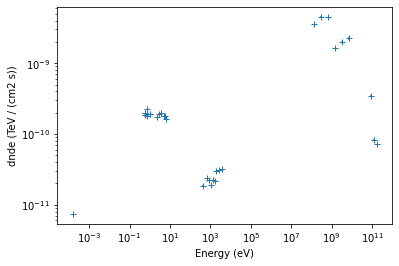

In [72]:
# print initial model
agnpy_ec = AgnpyEC()
sed_flux.plot(energy_unit="eV", energy_power=2)
agnpy_ec.plot(energy_range=[1e-6, 1e15] * u.eV, energy_unit="eV", energy_power=2)
plt.show()

In [73]:
# define model

model = SkyModel(name="PKS1510-089_EC", spectral_model= )
dataset_ec = FluxPointsDataset(model, sed_flux)
# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
dataset_ec.mask_fit = dataset_ec.data.energy_ref > E_min_fit

logging.info("performing the fit")

NameError: name 'ExpCutoffPowerLawSpectralModel' is not defined

In [65]:
%%time
sampler = run_mcmc(dataset_ec, nwalkers=16, nrun=500)  # to speedup the notebook

NameError: name 'dataset_ec' is not defined